In [24]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from tqdm.notebook import tqdm
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import glob
import os
import sys

from tqdm.notebook import tqdm
from datetime import datetime

import Cross_Eval
from Preprocessing_Methods import *
from stratgroupkfold import StratifiedGroupKFold

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.calibration import CalibratedClassifierCV

from sklearn.kernel_approximation import RBFSampler, Nystroem

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold, KFold, train_test_split

from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.utils import compute_class_weight, compute_sample_weight

from mlxtend.evaluate import scoring
from mlxtend.evaluate import BootstrapOutOfBag

# Preparing Metadata/Labels

In [26]:
all_files = pd.DataFrame(glob.glob("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])

try:all_files = pd.DataFrame(glob.glob("/mnt/d/Conor/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])
except:all_files = pd.DataFrame(glob.glob("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])

all_files = pd.DataFrame(glob.glob("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])

all_files["TMA"] = all_files.apply(lambda row: float(row["hdf_loc"].split("/")[-1][4:5]), axis = 1)
all_files["Core"] = all_files.apply(lambda row: row["hdf_loc"].split("/")[-1][8:-7], axis = 1)

In [27]:
try:metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx", sheet_name = "reformatted")
except:metadata = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx", sheet_name = "reformatted")

metadata = metadata.merge(all_files, left_on = ["TMA", "TMA site"], right_on = ["TMA", "Core"])
print(metadata.shape)

try:new_metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/new_metadata.xlsx")
except:new_metadata = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/new_metadata.xlsx")

(79, 18)


In [28]:
new_metadata["DODvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "DOD",
                             "alive": "Other",
                             "died other" : "Other",
                             "died" : "Other",
                             "Died" : "Other",
                             "Died other": "Other"})

new_metadata["DiedvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "Died",
                             "alive": "Alive",
                             "died other" : "Died",
                             "died" : "Died",
                             "Died" : "Died",
                             "Died other": "Died"})

new_metadata["ECS"] = new_metadata["ECS"].map(
                            {"y" : "Y",
                             "Y": "Y",
                             "N" : "N",
                             "n" : "N"})

In [29]:
new_metadata['lifespan'] = new_metadata['Date of death'] - new_metadata['date of diag']
new_metadata["Years"] = new_metadata['Date of death'].dt.year - new_metadata['date of diag'].dt.year

In [30]:
# Did the patient survive beyond n years?
for i in np.arange(0,5,1):
    
    s = (365*i)
    e = (365*(i+2))
    
    new_metadata[f"{i+1}year"] = new_metadata.apply(lambda row: True if s<(row['lifespan']).days<e and row.OUTCOME not in ['Alive',"alive"] else False, axis = 1)

In [31]:
new_metadata[f"1yeardeath"] = new_metadata.apply(lambda row: True if (row['lifespan']).days<365 and row.OUTCOME not in ['Alive',"alive"] else False, axis = 1)

bins = np.arange(0, new_metadata["Years"].max(),2)

new_metadata["2years"] = np.digitize(new_metadata["Years"], bins)

# Import ASMA data

In [33]:
try:asma = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")
except:asma = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")

new_metadata = new_metadata.merge(asma, left_on = "Patient_Number", right_on = "Case ID")

In [34]:
new_metadata

,Patient_Number,gender,date of diag,age @ diag,site,pT,pN,stage,ECS,OUTCOME,...,Years,1year,2year,3year,4year,5year,1yeardeath,2years,Case ID,ASMA
0,3143,m,2004-03-29,58,floor of mouth,4,0,4,N,DOD,...,9.0,False,False,False,False,False,False,5,3143,H
1,3167,m,2004-09-30,74,floor of mouth,2,2,4,Y,DOD,...,1.0,True,True,False,False,False,False,1,3167,H
2,3169,m,2004-10-28,63,floor of mouth,3,1,3,N,died other,...,2.0,True,True,False,False,False,False,2,3169,L
3,3170,m,2004-11-22,59,other,4,2b,4a,Y,Died other,...,10.0,False,False,False,False,False,False,6,3170,H
4,3230,m,2006-01-26,74,tongue,2,1,3,Y,DOD,...,0.0,True,False,False,False,False,True,1,3230,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,3568,m,2010-03-04,74,floor of mouth,2,2c,4a,Y,died other,...,0.0,True,False,False,False,False,True,1,3568,H
98,3574,m,2010-04-15,51,tongue,2,2b,4a,N,died other,...,5.0,False,False,False,False,True,False,3,3574,I
99,3578,f,2010-04-26,44,other,4,2b,NaN,Y,alive,...,NaN,False,False,False,False,False,False,6,3578,NaN
100,3583,m,2010-06-07,56,tongue,3,2b,4a,Y,alive,...,NaN,False,False,False,False,False,False,6,3583,L


# Import data and preprocess

select = ['Tumour']

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).query(f"Tissue in {select}").sample(frac = 1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns
#total = total.merge(new_metadata, left_on = "Patient nu ", right_on = "Patient Number")
#total = total.drop(np.nan, level = "Overall Death ")

In [35]:
total

15.0               0.022729   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            15.0               0.022382   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            15.0               0.023112   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            15.0               0.022800   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ...   
                   True         False 1      False False False H      H      3484.0    3484      oral tongue              DOD        2009-12-02    2009-09-09         52.0          Died        yes   Y     2.0-H11 NaT                2020-04-21   2b      DOD     PG                 yes            pT3N2bM0         3484           3484.0      yes         3       2.0 H11      0.0   island               52         2009-01-26   mod  m        m        310 days 2b 3  Yes          yes        tongue         regional & mets    NaN   12.0               0.026437   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            12.0               0.026096   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            12.0               0.035534   
                                                                                    

In [11]:
total=pd.read_hdf('Kohler_Raw_Data_1703.hdf', key='Data')

wn_cols = total.head().iloc[:,1:754].columns
oc = total.columns.difference(wn_cols).values

total_n=total.loc[:,wn_cols].set_index(pd.MultiIndex.from_arrays(total.loc[:,oc].values.T, names=oc.T))

total = total_n.iloc[:,26:234]

select = ['Tumour']

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).sample(frac = 1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns
#total = total.merge(new_metadata, left_on = "Patient nu ", right_on = "Patient Number")
#total = total.drop(np.nan, level = "Overall Death ")

In [19]:
new_metadata.sample(3)

,Patient_Number,gender,date of diag,age @ diag,site,pT,pN,stage,ECS,OUTCOME,...,Years,1year,2year,3year,4year,5year,1yeardeath,2years,Case ID,ASMA
39,3383,m,2008-01-24,55,other,1,0,4a,N,died other,...,6.0,False,False,False,False,False,False,4,3383,NaN
61,3482,m,2009-01-22,77,other,NaN,NaN,NaN,N,died,...,0.0,True,False,False,False,False,True,1,3482,NaN
37,3354,f,2007-08-30,48,tongue,2,1,3,N,alive,...,NaN,False,False,False,False,False,False,6,3354,L


In [18]:
total.sample(5)

live      FGD                no             pT1N0Mx          3288           3288.0      yes         1       1.0 F5       NaN   non-cohesive         29         2006-11-13   well     m        m        NaT      0  1  yes          yes        tongue         regional only      1     131.0              0.014596   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1781.0  \
1year 1yeardeath_x 1yeardeath_y 2year 2years 3year 4year 5year ASMA_x ASMA_y Case ID_x Case ID_y Corrected Site AJCC/UICC DODvsAlive Date of death Date of recurrence Diagnosis Age DiedvsAlive ECS_x ECS_y ID      Last seen/reviewed Last updated N stage OUTCOME    OUTCOME.updated by Overall Death  Pathogical Stage Patient_Number Patient_nu  Recurrence? T stage TMA TMA site Years advancing front type age @ diag date of diag diff     gender_x gender_y lifespan pN pT radiotherapy recurrence site           site of recurrence stage survival (months)             
True  True         True         False 1      False False False H      H      3251.0    3251      oral tongue              DOD        2006-07-21    NaT                70.0          Died        yes   Y     2.0-B1  NaT                2020-03-13   1       DOD        FG                 yes            pT4N1M0          3251           3251.0      no          4       2.0 B1       0.0   islands              70         2006-05-31   mod      m        m        51 days  1  4  no           no         tongue         NaN                4     2.0                0.043556   
False False        False        False 6      False False False I      I      3271.0    3271      FOM                      Other      NaT           2010-07-23         59.0          Alive       yes   Y     1.0-A10 2010-07-23         2020-04-01   2b      alive      FGD                no             pT4N2bM0         3271           3271.0      yes         4       1.0 A10      NaN   poorly cohesive      59         2006-09-16   mod      m        m        NaT      2b 4  yes          yes        floor of mouth lung mets          4a    46.0              -0.020781   
True  True         False        True  1      False False False I      I      3237.0    3237      other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     2.0-B5  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237           3237.0      no          4a      2.0 B5       1.0   non-cohesive         59         2006-03-24   mod well m        m        574 days 2a 4a yes          yes        other          NaN                4     2.0                0.039960   
                   True         False 1      False False False H      H      3568.0    3568      FOM                      Other      2010-04-17    NaT                74.0          Died        yes   Y     2.0-B8  NaT                2020-04-01   2c      died other FGD                yes            pT2N2cMx         3568           3568.0      no          2       2.0 B8       0.0   NaN                  74         2010-03-04   NaN      m        m        44 days  2c 2  no           no         floor of mouth NaN                4a    1.0                0.064838   
False False        False        False 6      False False False H      H      3288.0    3288      oral tongue              Other      NaT           2009-10-14         29.0          Alive       no    N     1.0-F5  2019-10-23         2020-04-01   0       alive      FGD                no             pT1N0Mx          3288

In [14]:
total = total.reset_index().merge(new_metadata, left_on = "Patient_nu ", right_on = "Patient_Number", how = 'inner')
total = total.set_index(list(total.columns.difference(wn_cols))).dropna(axis = 1)

total.reset_index().loc[:,['ID', 'Annotation_loc','envi_loc', 'Patient_Number']].drop_duplicates(subset='Patient_Number').to_excel('./metadata.xlsx')

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).sample(frac = 0.1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns

total.to_hdf("./Tumour_df_raw.hdf5", key='Data')

In [15]:
total.index.names

FrozenList(['1year', '1yeardeath_x', '1yeardeath_y', '2year', '2years', '3year', '4year', '5year', 'ASMA_x', 'ASMA_y', 'Case ID_x', 'Case ID_y', 'Corrected Site AJCC/UICC', 'DODvsAlive', 'Date of death', 'Date of recurrence', 'Diagnosis Age', 'DiedvsAlive', 'ECS_x', 'ECS_y', 'ID', 'Last seen/reviewed', 'Last updated', 'N stage', 'OUTCOME', 'OUTCOME.updated by', 'Overall Death ', 'Pathogical Stage', 'Patient_Number', 'Patient_nu ', 'Recurrence?', 'T stage', 'TMA', 'TMA site', 'Years', 'advancing front type', 'age @ diag', 'date of diag', 'diff', 'gender_x', 'gender_y', 'lifespan', 'pN', 'pT', 'radiotherapy', 'recurrence', 'site', 'site of recurrence', 'stage', 'survival (months)'])

Text(0, 0.5, 'Absorbance (a.u)')

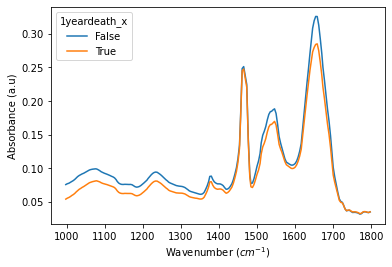

In [16]:
fig, axes = plt.subplots(nrows = 1, figsize = (6,4), sharex = True)

total.groupby("1yeardeath_x").mean().T.plot(ax = axes)
axes.set_xlabel("Wavenumber $(cm^{-1})$")
axes.set_ylabel("Absorbance (a.u)")
#fig.savefig(os.getcwd()+ "/Plots/Mean_ECS_Spectra.png", bbox_inches = 'tight')

In [17]:
total.head()

15.0               0.023463   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           15.0               0.022842   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                1781.0  \
1year 1yeardeath_x 1yeardeath_y 2year 2years 3year 4year 5year ASMA_x ASMA_y Case ID_x Case ID_y Corrected Site AJCC/UICC DODvsAlive Date of death Date of recurrence Diagnosis Age DiedvsAlive ECS_x ECS_y ID     Last seen/reviewed Last updated N stage OUTCOME OUTCOME.updated by Overall Death  Pathogical Stage Patient_Number Patient_nu  Recurrence? T stage TMA TMA site Years advancing front type age @ diag date of diag diff gender_x gender_y lifespan pN pT radiotherapy recurrence site           site of recurrence stage survival (months)             
True  False        False        True  1      False False False I      I      3254.0    3254      FOM                      DOD        2007-10-22    2007-08-09         48.0          Died        no    N     2.0-A2 NaT                2012-10-04   2c      DOD     CBarry             yes            pT2N2cMx         3254           3254.0      yes         2       2.0 A2       1.0   islets               48         2006-06-12   mod  f        f        497 days 2c 2  yes          yes        floor of mouth metastases         4     15.0               0.028968   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           15.0               0.025614   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           15.0               0.026051   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           15.0               0.024463   
                                                                                          

# Kaplan Meier

In [46]:
from lifelines import KaplanMeierFitter

In [47]:
pats = total.groupby('Patient_nu ').sample(1).reset_index().iloc[:,:-169]

In [48]:
duration  = pats['survival (months)']
death_obs = np.array([1 if i!='Died' else 0 for i in pats['DiedvsAlive']])

In [49]:
kmf = KaplanMeierFitter()

fig, ax = plt.subplots()

group = 'ASMA'

for g in pats[group].dropna().unique():

    kmf.fit(duration[(pats[group]==g)], death_obs[(pats[group]==g)], label=g)
    kmf.plot(ax=ax, ci_show=False)

KeyError: 'ASMA'

In [ ]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.cross_decomposition import PLSRegression

class PLSRegressionWrapper(PLSRegression):

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)

In [ ]:
numeric_pipe = Pipeline([
("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
#("Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
#("Normalise spectra", FunctionTransformer(minmax_scale, kw_args = {"axis": 1})),
("Scaler", MinMaxScaler()),
#("Scaler", StandardScaler()),
("PCA", PCA(0.99)),
#('PLS', PLSRegressionWrapper(n_components=10))
])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

in_df = total.reset_index(['ASMA']).dropna().sample(1000)
#in_df = total.sample(10000)

in_df.columns = [str(col) for col in in_df.columns]

ct = make_column_transformer(
    (numeric_pipe,     make_column_selector(dtype_include=np.number)),
    (categorical_pipe, make_column_selector(dtype_include=object))
)

In [ ]:
preproc = pd.DataFrame(ct.fit_transform(in_df, in_df.reset_index()['1yeardeath']), index = in_df.index)

# Bayesian Logistic Regression

In [ ]:
import pymc3 as pm
import theano as th

y = "1yeardeath"

train_pat, test_pat = train_test_split(pats.reset_index()['Patient_Number'], test_size=0.33, random_state=np.random.randint(0,100))


train_data = preproc.query(f"Patient_Number in {list(train_pat)}")
test_data = preproc.query(f"Patient_Number in {list(test_pat)}")

X_train = train_data
X_test = test_data

y_train, y_test = train_data.reset_index()[f"{y}"], test_data.reset_index()[f"{y}"]

print(train_data.reset_index()[y].value_counts())
print(test_data.reset_index()[y].value_counts())

ax=sns.pairplot(preproc.reset_index(['1yeardeath']).sample(100), hue='1yeardeath')

In [ ]:
ncon = 13
ncat = 3

with pm.Model() as logistic_model:

    data_ = pm.Data('Pred', X_train.T)

    ɛ = pm.HalfNormal('ɛ', sd=1, shape = (ncat+ncon+1,1))
 
    # Continuous variables for each PC
    β1 = pm.Normal("β1", mu=0, sigma=1, shape = (ncon+1,1))

    # Categorical variables 
    β2 = pm.Categorical("β2", [1/ncat for _ in range(1, ncat+1)], shape=(ncat,1))

    # β.T + ɛ
    z = pm.math.dot(pm.math.concatenate([(β1[1:]+ɛ[1:-ncat]), (β2 + ɛ[-ncat:])]).T, data_)

    # Probability of parameter P given the data
    p = pm.Deterministic('P', pm.math.sigmoid(z + (β1[0] + ɛ[0])))

In [ ]:
with logistic_model:

    obs = np.array([1.0 if el else 0.0 for el in y_train])

    observed = pm.Bernoulli("p", p, observed=obs.T)
    start=pm.find_MAP()

    #trace = pm.sample(10000, tune=100, start=start, step=step)
    trace = pm.sample(1000, tune=3000, start=start, init="adapt_diag", cores=1)

In [ ]:
pm.model_graph.model_to_graphviz(logistic_model)

In [ ]:
def exp_mean(array):

    hist, edges = np.histogram(array)
    hist = hist/np.sum(hist)

    centres = (edges[:-1] + edges[1:])/2

    return np.sum(hist*centres)

In [ ]:
trace["P"]

In [ ]:
for i in [25,2,8]:
    
    plt.hist(trace["P"].squeeze()[:,i], histtype='step', density=True, label=f'Sample {i}')
    plt.axvline(trace["P"].squeeze()[:,i].mean(), ls='--', c='r')

plt.legend()
plt.xlabel('Prediction score')
plt.ylabel('Likelihood')

In [ ]:
for i in [9,4,8]:
    
    plt.hist(trace["β1"].squeeze()[:,i], histtype='step', density=True, label=f'β{i-1}')
    #plt.axvline(trace["β1"].squeeze()[:,i].mean(), ls='--', c='r')
    plt.axvline(lr.coef_[:,i-1], ls='--', c='r')


plt.legend()
plt.xlabel('Parameter Value')
plt.ylabel('Likelihood')

In [ ]:
p_df = pd.DataFrame(trace['P'].squeeze())

In [ ]:
y_score_U = np.mean(trace['P'], axis=0).flatten()

In [ ]:
y_score_w = p_df.apply(exp_mean, axis=0)

In [ ]:
obs.shape

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (18,5))

preds = [1 if el > 0.5 else 0 for el in y_score_U]

cm = confusion_matrix(obs, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)

fpr_w, tpr_w, thresh_w = roc_curve(obs, y_score_w);

print("Weighted: {}".format(roc_auc_score(obs, y_score_U)))
print("Unweighted: {}".format(roc_auc_score(obs, y_score_U.flatten())))

RocCurveDisplay(fpr=fpr_w, tpr=tpr_w).plot(label='weighted', ax=ax2)
#ax2.plot(fpr_u, tpr_u, label='unweighted')
ax2.legend();
ax2.set_title("ROC Curve")
ax2.plot([0,1],[0,1], ls='--')

prec, recall, _ = precision_recall_curve(obs, y_score_U)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
ax3.legend()

In [ ]:
with logistic_model:
    # update values of predictors:
    pm.set_data({"Pred": X_test.T})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["P"])

    model_preds = posterior_predictive["P"]

t_df = pd.DataFrame(model_preds.squeeze())

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

y_preds = lr.predict_proba(X_test)[:,1]

all = []    

thresholds = np.linspace(0,1,20)

for thresh in thresholds:

    preds = [1 if el > thresh else 0 for el in y_preds]

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.flatten()

    sens, spec = tp/(tp+fn), tn/(tn+fp)

    #print(f"Specificity: {spec}")
    #print(f"Sensitivity: {sens}")

    all.append(sens+spec)

op = thresholds[np.argmax(all)]



fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (18,5))

#y_preds = t_df.mean(axis=0)

preds = [1 if el > op else 0 for el in y_preds]

cm = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title("Confusion Matrix")
fpr_w, tpr_w, thresh_w = roc_curve(y_test, y_preds);

print("AUC: {:.2f}".format(roc_auc_score(y_test, y_preds)))
#print("Unweighted: {}".format(roc_auc_score(y_test, y_preds.flatten())))

RocCurveDisplay(fpr=fpr_w, tpr=tpr_w).plot(label='weighted', ax=ax2)
#ax2.plot(fpr_u, tpr_u, label='unweighted')
ax2.legend();
ax2.set_title("ROC Curve")
ax2.plot([0,1],[0,1], ls='--')

prec, recall, _ = precision_recall_curve(y_test, y_preds)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
ax3.legend()
ax3.set_title("Precision Recall Curve")

tn, fp, fn, tp = cm.flatten()

print(f"Specificity: {tn/(tn+fp):.2f}")
print(f"Sensitivity: {tp/(tp+fn):.2f}")


In [ ]:
all = []    

thresholds = np.linspace(0,1,20)

for thresh in thresholds:

    preds = [1 if el > thresh else 0 for el in y_preds]

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.flatten()

    sens, spec = tp/(tp+fn), tn/(tn+fp)

    #print(f"Specificity: {spec}")
    #print(f"Sensitivity: {sens}")

    all.append(sens+spec)

op = thresholds[np.argmax(all)]

In [ ]:
def row_max(row):

    hist, edges = np.histogram(row, bins=np.linspace(0,1,100))

    centres = (edges[:-1] + edges[1:])/2

    return centres[np.argmax(hist)]

In [ ]:
def row_sum(row):

    hist, edges = np.histogram(row, density=True, bins=np.linspace(0,1,100))

    centres = (edges[:-1] + edges[1:])/2

    return np.where(centres<0.5, hist, 0)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (18,5))

y_preds = t_df.apply(row_max, axis=0)
#y_preds = t_df.mean(axis=0)


all = []    

thresholds = np.linspace(0,1,20)

for thresh in thresholds:

    preds = [1 if el > thresh else 0 for el in y_preds]

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.flatten()

    sens, spec = tp/(tp+fn), tn/(tn+fp)

    #print(f"Specificity: {spec}")
    #print(f"Sensitivity: {sens}")

    all.append(sens+spec)

op = thresholds[np.argmax(all)]


preds = [1 if el > op else 0 for el in y_preds]

cm = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title("Confusion Matrix")
fpr_w, tpr_w, thresh_w = roc_curve(y_test, y_preds);

print("AUC: {:.2f}".format(roc_auc_score(y_test, y_preds)))
#print("Unweighted: {}".format(roc_auc_score(y_test, y_preds.flatten())))

RocCurveDisplay(fpr=fpr_w, tpr=tpr_w).plot(label='weighted', ax=ax2)
#ax2.plot(fpr_u, tpr_u, label='unweighted')
ax2.legend();
ax2.set_title("ROC Curve")
ax2.plot([0,1],[0,1], ls='--')

prec, recall, _ = precision_recall_curve(y_test, y_preds)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
ax3.legend()
ax3.set_title("Precision Recall Curve")

tn, fp, fn, tp = cm.flatten()

print(f"Specificity: {tn/(tn+fp):.2f}")
print(f"Sensitivity: {tp/(tp+fn):.2f}")

In [ ]:
import arviz as az

In [ ]:
kmf = KaplanMeierFitter()

pats = total.groupby('Patient_Number').sample(1).reset_index().iloc[:,:-169]

duration  = pats['survival (months)']
death_obs = np.array([1 if i!='Died' else 0 for i in pats['DiedvsAlive']])

fig, ax = plt.subplots()

group = 'ASMA'

for g in pats[group].dropna().unique():

    kmf.fit(duration[(pats[group]==g)], death_obs[(pats[group]==g)], label=g)
    kmf.plot(ax=ax, ci_show=False)